# Úkol č. 1 - redukce dimenzionality a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz/BI-ML2/homeworks/index.html](https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzazším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>

  * Použijte natrénovaný generativní model Naivního Bayesova klasifikátoru nebo Lineární diskriminační analýzy (podle Vaší volby) a vygenerujte pro každou třídu 5 datových bodů, které následně přetransformujte do rozměrů 28x28 a zobrazte pomocí `imshow`. Diskutujte kvalitu vygenerovaných dat. K vygenerování můžete využít funkci [multivariate_normal](https://numpy.org/doc/2.2/reference/random/generated/numpy.random.multivariate_normal.html) z `numpy`.

  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky aplikace modelů (žádné další generování už nedělejte) a pokuste se je vylepšit.
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
       * Ukázka, jak by mělo vypadat prvních několik řádků souboru `results.csv` (obecně s jinými hodnotami):
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

Importing needed libraries

In [160]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
%matplotlib inline 

random_seed = 333

# Data observation

Reading the data set form the csv file and getting acquainted with the data set

In [5]:
df = pd.read_csv("train.csv")

In [6]:
print(df.shape)
display(df.head())

(1500, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,95,132,90,0,0,0
2,1,0,0,0,0,0,0,3,0,23,...,94,68,44,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,57,0,0,0,26,71,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,6,156,149,78,0,0,0,0


Checking for any missing values in the data set, there are none

In [7]:
df.isnull().sum().sum()

np.int64(0)

Describing the data set to get the basic info, pixels seem to be in the boundaries (0, 255) and have no missing values (double check)

In [8]:
df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,1500.000000,1500.0,1500.0,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.0000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.494000,0.0,0.0,0.003333,0.014667,0.094000,0.172000,0.696667,1.560667,3.672000,...,45.751333,26.884000,12.8060,24.222667,36.824000,27.227333,10.798000,1.529333,0.129333,0.012667
std,0.500131,0.0,0.0,0.085599,0.196156,1.645692,1.935522,7.234884,12.065794,17.912854,...,60.907953,48.747801,32.4854,51.600777,65.053729,54.335598,31.792269,12.227598,3.098872,0.369591
min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,86.000000,36.000000,1.0000,7.000000,55.500000,18.250000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.0,0.0,3.000000,5.000000,53.000000,52.000000,136.000000,216.000000,183.000000,...,240.000000,227.000000,231.0000,255.000000,249.000000,251.000000,244.000000,171.000000,97.000000,13.000000


Extracting the label column to plot some images

In [9]:
to_plot = df.iloc[:,1:]
to_plot.shape

(1500, 784)

Function, that for a certain array of images will show them with the label of class it belongs to

In [10]:
def plot_grid(images: np.array, titles: np.array, rows: int, cols: int):
    fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        img = np.reshape(images[i], (28, 28))
        ax.set_title(titles[i])
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

Showing 10 first images from the dataset

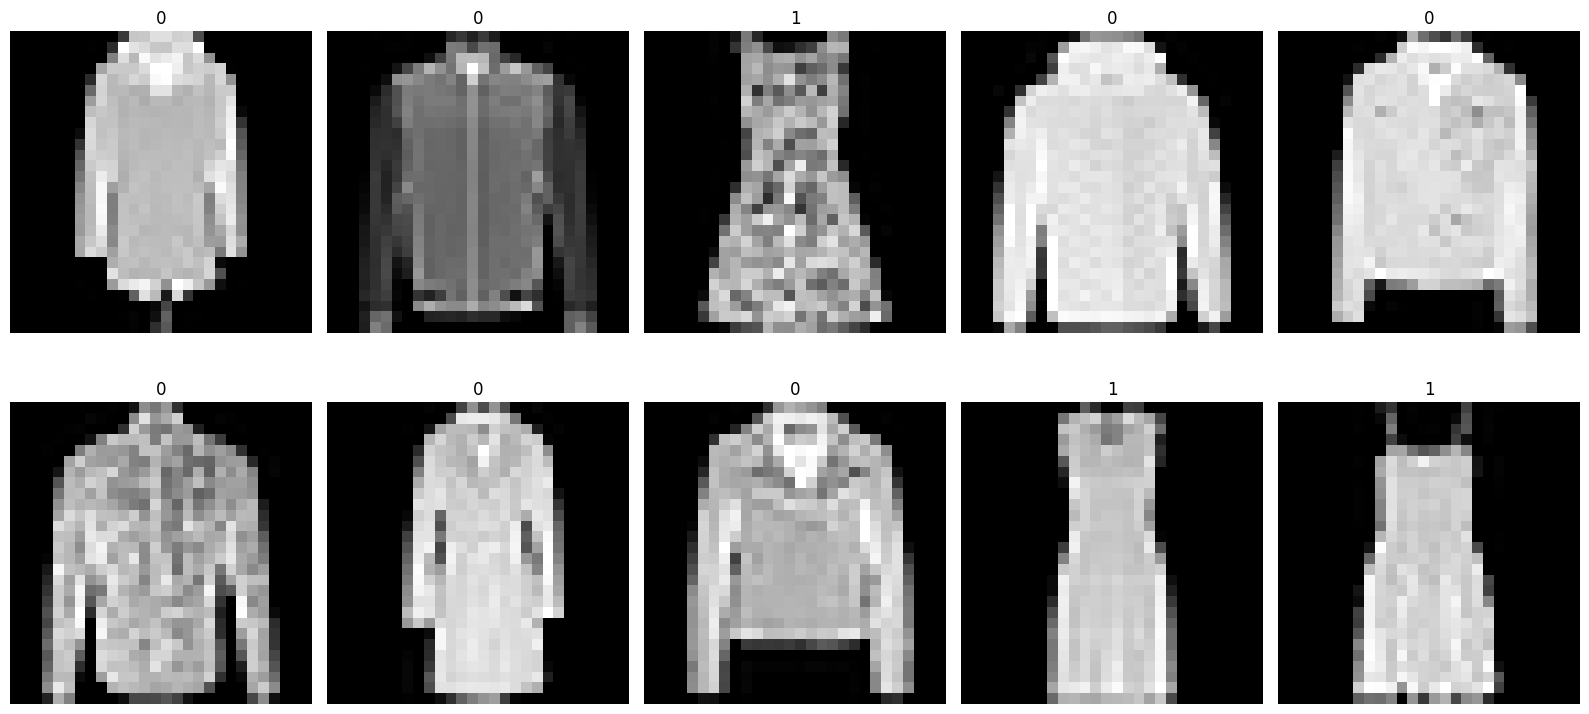

In [11]:
titles = df.iloc[:10,0]
plot_grid(np.array(to_plot.iloc[:10, :]), titles, 2, 5)

Splitting the data into the 60% train, 20% evaluation and 20% test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df["label"], test_size=0.4, random_state=random_seed)

In [13]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_seed)

Checking the shapes of the subsets to make sure splitting was succesfull

In [14]:
print(f"X_train, y_train: {X_train.shape}, {y_train.shape}\nX_val, y_val: {X_val.shape}, {y_val.shape}\nX_test, y_test: {X_test.shape}, {y_test.shape}")

X_train, y_train: (900, 784), (900,)
X_val, y_val: (300, 784), (300,)
X_test, y_test: (300, 784), (300,)


# Gaussian Naive Bayes

**I chose the Gaussian variation as it aligns well with continuous data** <br>
As there are no usefull hyperparametrs to train model with, I just stick with the basic version of model <br>
Its efficient and can be a good baseline model

In [15]:
clf = GaussianNB()
clf.fit(X_train, y_train)
print(f"Training accuracy: {clf.score(X_train, y_train):.4f}")
print(f"Validation accuracy {clf.score(X_val, y_val):.4f}")

Training accuracy: 0.8744
Validation accuracy 0.8600


# Support Vector Machine (Classifier)

It is well-suited for high-dimensional data as we have and it can handle non-linear decision boundaries effectively, which might be the case in concerning we work with images

In [20]:
param_grid = {
    "C": list(range(1, 100, 5)) + [x/10 for x in range(1, 10, 2)],
    "gamma": [1/np.pow(10, i) for i, _ in enumerate (range(6))],
    "kernel": ["rbf", "poly", "linear"]
}
param_comb = ParameterGrid(param_grid)

In [21]:
val_metric = []
for params in param_comb:
    clf = SVC(**params)
    clf.fit(X_train, y_train)
    val_metric.append(clf.score(X_val, y_val))
best_svc_params = param_comb[np.argmax(val_metric)]
print(f"We found the best params {best_svc_params}.")

We found the best params {'kernel': 'poly', 'gamma': np.float64(1.0), 'C': 1}.


In [15]:
best_svc = SVC(**best_svc_params)
best_svc.fit(X_train, y_train)
print(f"Training accuracy: {best_svc.score(X_train, y_train):.4f}")
print(f"Validation accuracy: {best_svc.score(X_val, y_val):.4f}")

Training accuracy: 1.0000
Validation accuracy: 0.9433


# Quadratic Discriminant Analysis (Gaussian)

By assuming each class has its own covariance matrix we can work wieth curved decision boundaries. This makes it a good fit for image data where the class distributions might not share the same shape or orientation in feature space. <br> 
While training with reg param we see, that the best results are when reg param is somewhat near 0.99 it gives us intuition for the huge collinieation. 

In [92]:
reg_p = [x/100 for x in range(101)]
val_metric = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for param in reg_p:
        clf = QuadraticDiscriminantAnalysis(reg_param=param)
        clf.fit(X_train, y_train)
        val_metric.append(clf.score(X_val, y_val))
best_reg_param = reg_p[np.argmax(val_metric)]
print(f"The best regulating parameter for the QuadraticDiscriminantAnalysis was {best_reg_param}")

The best regulating parameter for the QuadraticDiscriminantAnalysis was 0.99


In [93]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_kvda = QuadraticDiscriminantAnalysis(reg_param=best_reg_param, store_covariance=True)
    best_kvda.fit(X_train, y_train)
print(f"Training accuracy: {best_kvda.score(X_train, y_train):.4f}")
print(f"Validation accuracy: {best_kvda.score(X_val, y_val):.4f}")

Training accuracy: 1.0000
Validation accuracy: 0.9300


# Linear Discriminant Analysis (LDA)

Because LDA supposes all each class has the same cov matrix, works especially well when class distributions are approximately Gaussian with shared covariance

In [84]:
clf = LinearDiscriminantAnalysis(store_covariance=True)
clf.fit(X_train, y_train)
print(f"Training accuracy: {clf.score(X_train, y_train):.4f}")
print(f"Validation accuracy: {clf.score(X_val, y_val):.4f}")

Training accuracy: 1.0000
Validation accuracy: 0.8067


# Generating new data

A function generates images data for two classes using multivariate Gaussian sampling. We get class-specific mean vectors (mean_0, mean_1) and covariance matrices (cov_0, cov_1) to sample 5 new instances from each class via np.random.multivariate_normal

In [87]:
def generate_clothes(mean_0: np.array, mean_1: np.array, cov_0: np.array, cov_1: np.array):
    tops = []
    trousers = []
    for i in range(5):
        top = np.random.multivariate_normal(mean_0, cov_0)
        tops.append(top)
        trouser = np.random.multivariate_normal(mean_1, cov_1)
        trousers.append(trouser)
    cl_0 = np.array(tops)
    cl_1 = np.array(trousers)
    images = np.concatenate((cl_0, cl_1))
    titles = np.array(([0] * 5) + ([1] * 5))
    plot_grid(images, titles, 2, 5)

**Generating the data using the GaussianNB:** <br>
The images for each class turned out to be very "blurry" and similar as we are using diagonal covariance (no pixel dependencies). And so no regularization or correlation between pixels is captured.

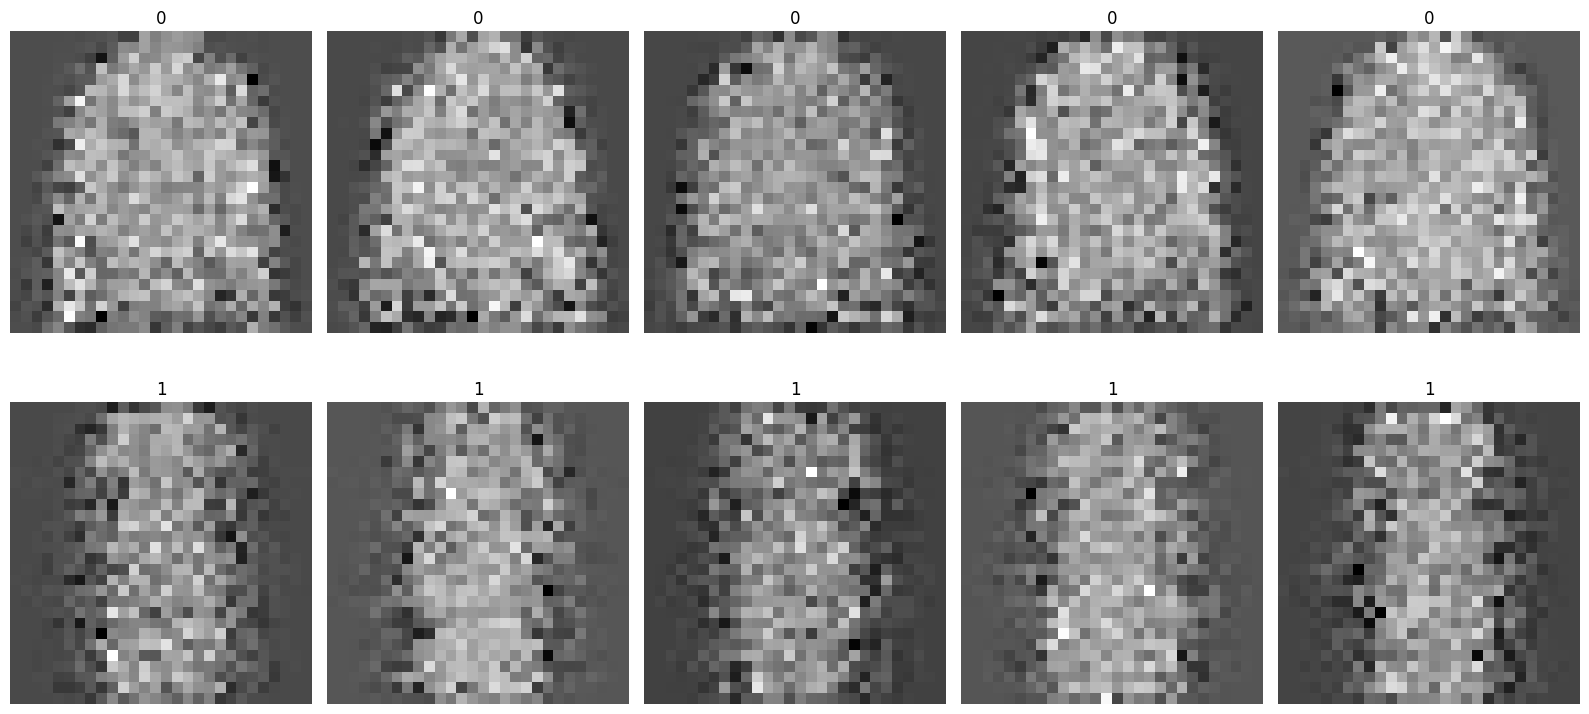

In [89]:
clf = GaussianNB()
clf.fit(X_train, y_train);
generate_clothes(clf.theta_[0], clf.theta_[1], np.diag(clf.var_[0]), np.diag(clf.var_[1]))

**Generating the data using the LDA:** <br>
We got better results as we store the full covariance matrix this time (clf.covariance_), so we capture pixel relationships. In differnce of naive bayes, instead of independent pixel noise, we got variations that actually make images look better

In [353]:
clf = LinearDiscriminantAnalysis(store_covariance=True)
clf.fit(X_train, y_train);

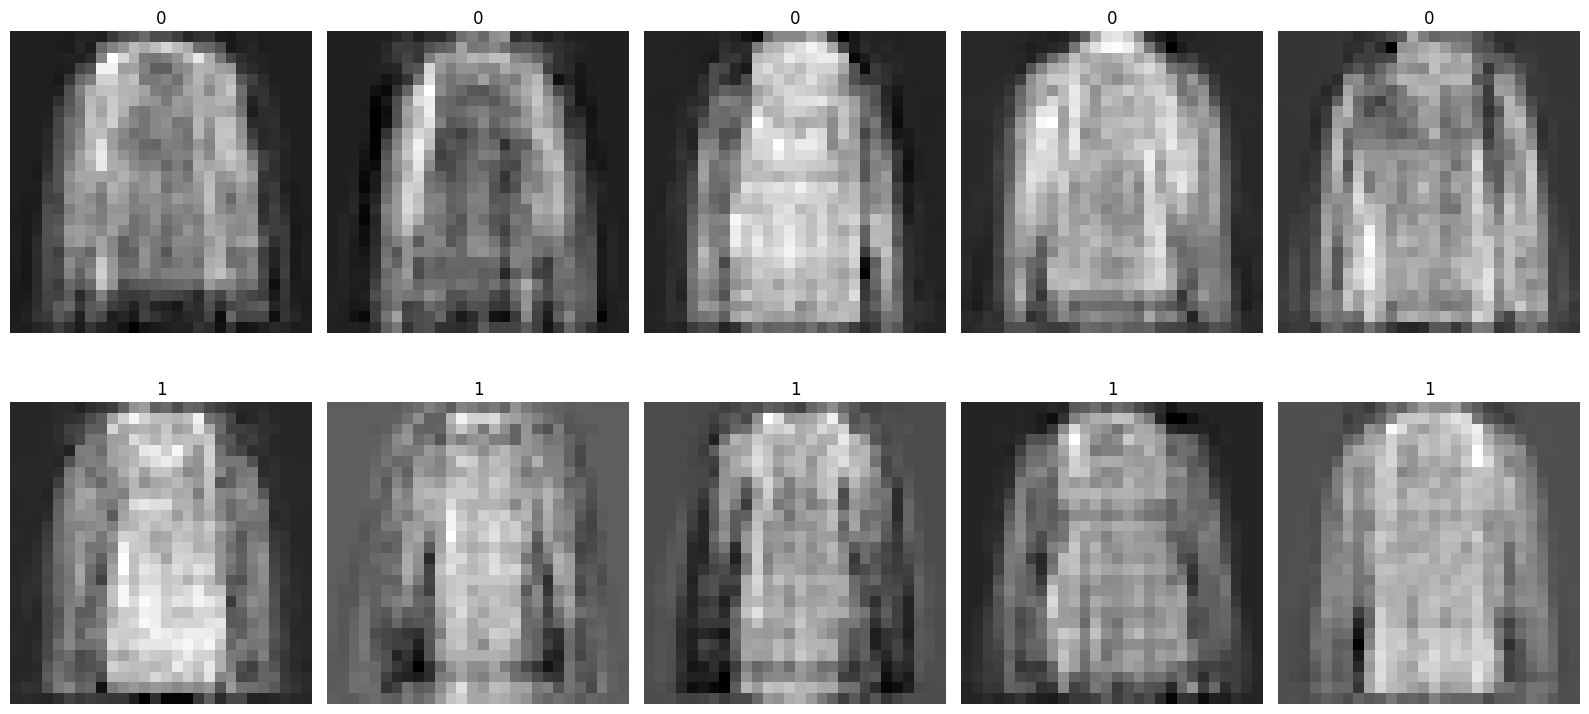

In [355]:
generate_clothes(clf.means_[0], clf.means_[1], clf.covariance_, clf.covariance_)

**Generating the data using the "best" QDA:** <br>
We got almost identical results for each class, but clothes itself looks really realistic. We stored for each class has its own covariance matrix. That reflects differences between shirts and dresses better than shared covariance (LDA). Because the reg param is 0.99 it strongly pushes the covariance toward the identity matrix, so the samples a centered tightly around the mean

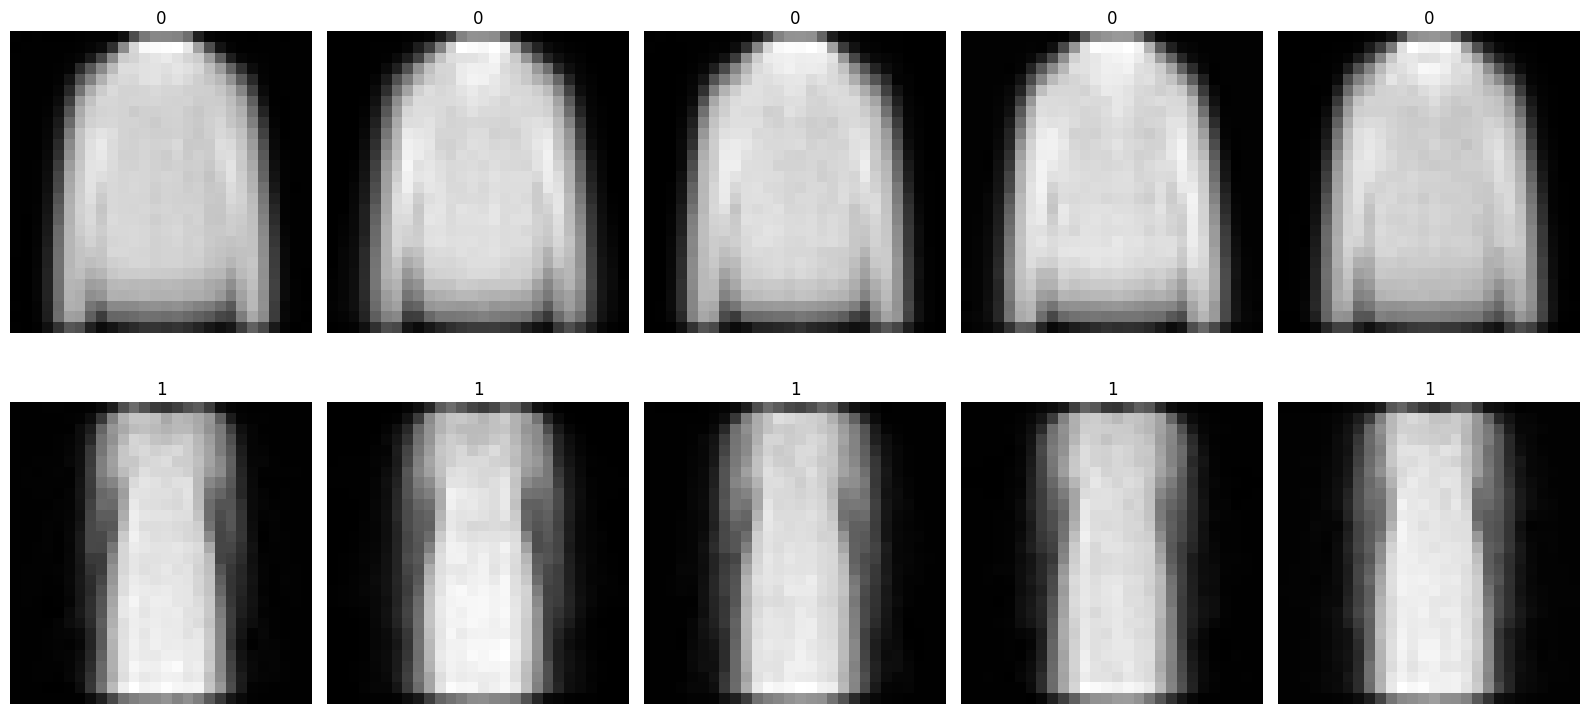

In [94]:
generate_clothes(best_kvda.means_[0], best_kvda.means_[1], best_kvda.covariance_[0], best_kvda.covariance_[1])

**Generating the data using the standart QDA:** <br>
A big varince in clothes when we don't use reg param. Because we store a cov matrix for each class we also get better look, comparing with LDA

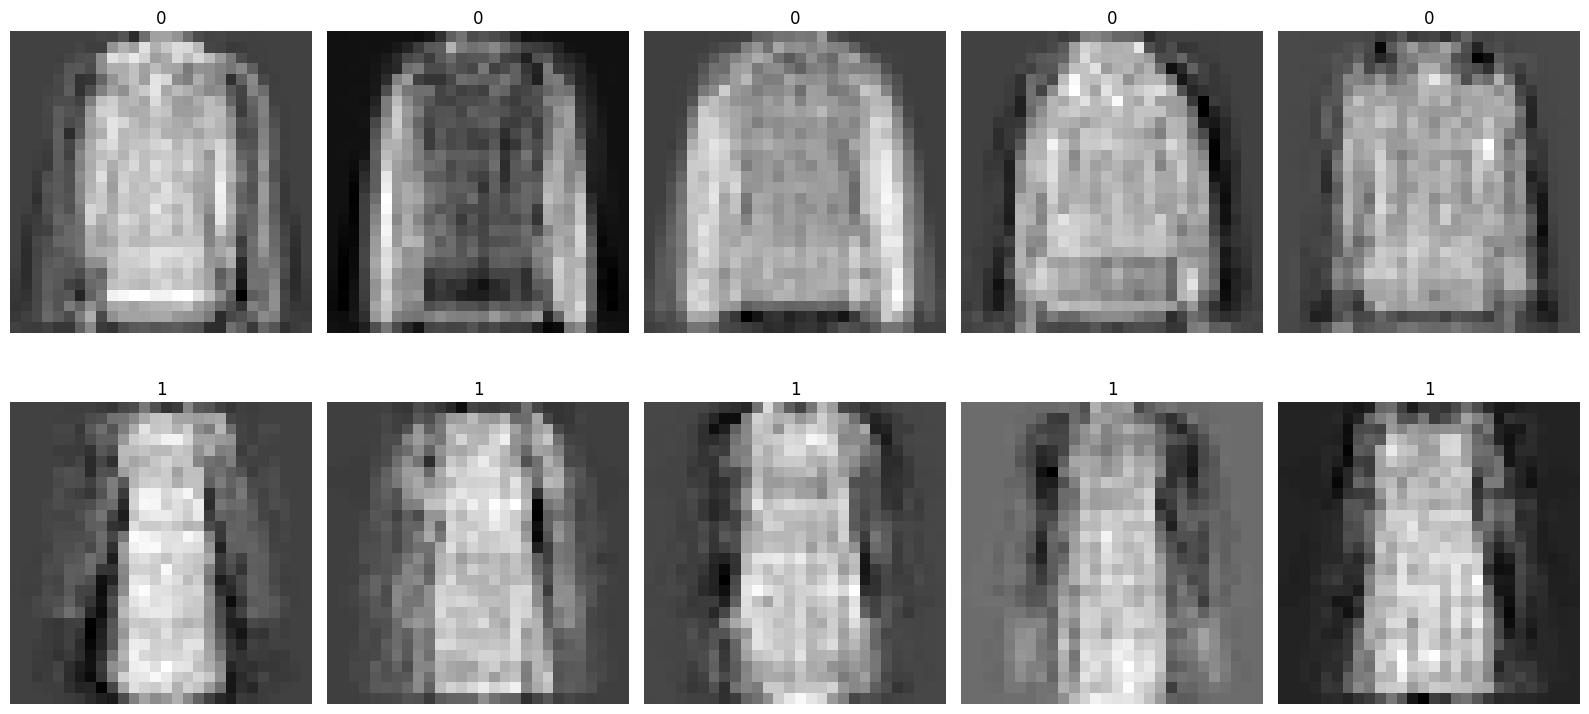

In [95]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    l = QuadraticDiscriminantAnalysis(store_covariance=True)
    l.fit(X_train, y_train)

generate_clothes(l.means_[0], l.means_[1], l.covariance_[0], l.covariance_[1])

# PCA

Training the PCA on the whole dataset, so that while training data we will just slice the PCA applied data, which will be more efficien, than each time train the PCA on sliced original dataset

In [50]:
pca = PCA()
pca.fit(X_train)
pca_train = pca.transform(X_train)
pca_val = pca.transform(X_val)

A funciton, that will plot the result for the PCA. It plots the best result for the curr dimension (the best hyperparamets for the model are chosed each time)

In [51]:
def plot_pca(res: np.array, title: str, offset:int=0):
    plt.figure(figsize=(16, 8))

    vals = offset * [None] + res
    plt.plot(vals, "-", color="darkkhaki")
    plt.axhline(y=np.max(res), color="red", linestyle="--")
    plt.axvline(x=np.argmax(res)+offset, color="green", linestyle="--")
    
    xticks = [x*100 for x in range(8)] + [np.argmax(res) + offset, offset, 784]
    plt.xticks(ticks=xticks)
    yticks = np.round(np.linspace(np.min(res), np.max(res), 6), 3).tolist()
    plt.yticks(ticks=yticks)
    
    plt.xlim([0, 784])
    
    plt.title(title)
    plt.xlabel("# of principal components")
    plt.ylabel("Validation Accuracy")
    
    plt.show()

# PCA with Gaussian Naive Bayes

In [52]:
acc_gnb_pca = []

for i in range(1, 785):
    sliced_pca_train = pca_train[:,0:i]
    sliced_pca_val = pca_val[:,0:i]
    clf = GaussianNB()
    clf.fit(sliced_pca_train, y_train)
    acc_gnb_pca.append(clf.score(sliced_pca_val, y_val))    

In [53]:
print(f"the best result is {np.max(acc_gnb_pca)} for dim {np.argmax(acc_gnb_pca)}")

the best result is 0.9133333333333333 for dim 61


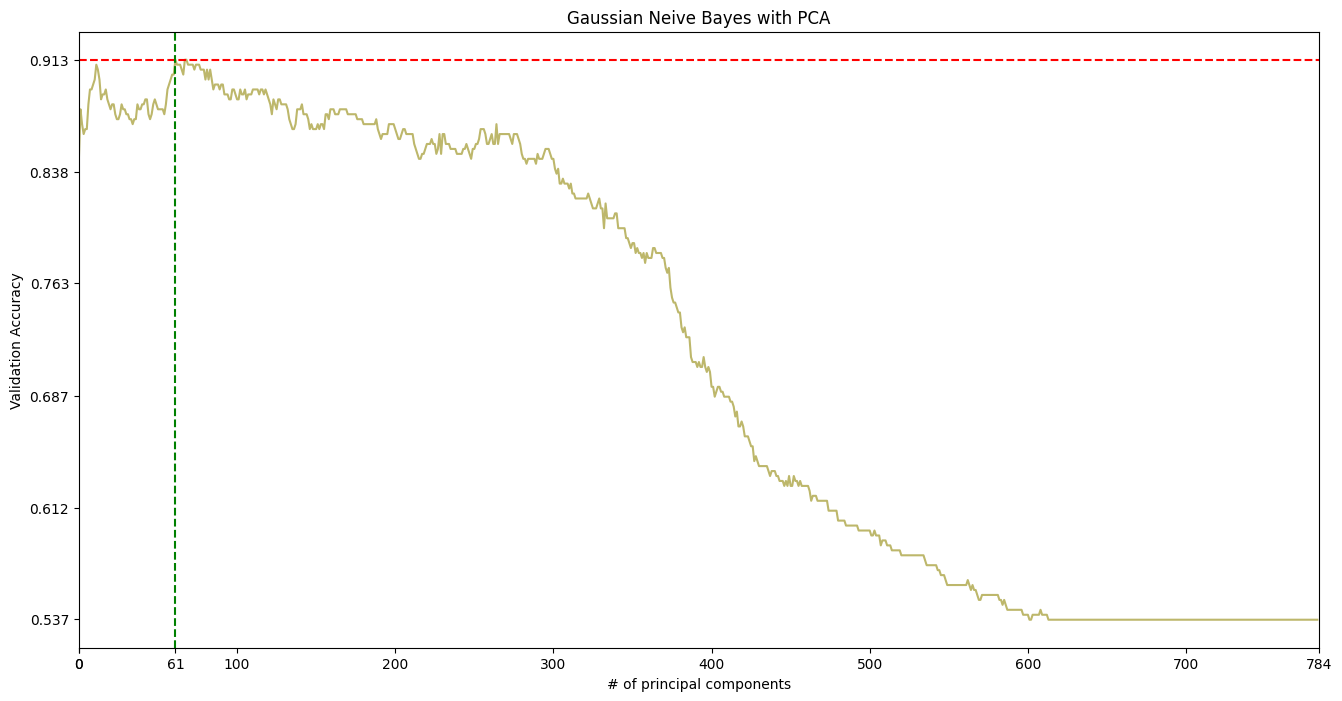

In [54]:
plot_pca(acc_gnb_pca, "Gaussian Neive Bayes with PCA")

# PCA with SVM

In [55]:
acc_cvc_pca = []
curr_best_param = []

param_grid = {
    "C": list(range(1, 20, 2)) + [x/10 for x in range(1, 10, 2)],
    "gamma": [1/np.pow(10, i) for i, _ in enumerate (range(6))],
    "kernel": ["rbf", "poly"]
}

param_comb = ParameterGrid(param_grid)

for i in range(10, 785):
    sliced_pca_train = pca_train[:,0:i]
    sliced_pca_val = pca_val[:,0:i]
    val_metric = []
    for params in param_comb:
        clf = SVC(**params)
        clf.fit(sliced_pca_train, y_train)
        val_metric.append(clf.score(sliced_pca_val, y_val))
    curr_best_param.append(param_comb[np.argmax(val_metric)])
    acc_cvc_pca.append(np.max(val_metric))
    #print(f"We found the best params {best_svc_params} with the accuracy {np.max(val_metric)} for the {i} dim using PCA")

In [56]:
print(f"The max score is {np.max(acc_cvc_pca)} with the {np.argmax(acc_cvc_pca) + 10} components with the params: {curr_best_param[np.argmax(acc_cvc_pca)]}")

The max score is 0.95 with the 57 components with the params: {'kernel': 'poly', 'gamma': np.float64(1.0), 'C': 1}


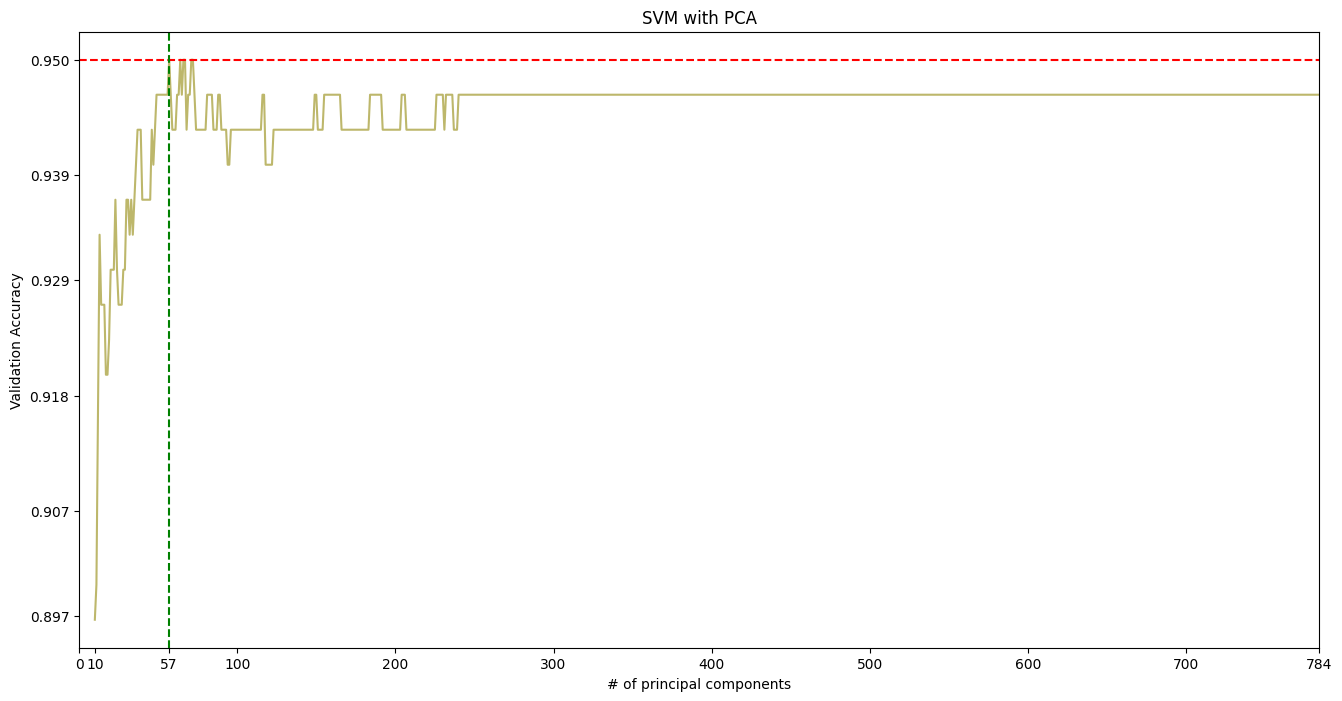

In [57]:
plot_pca(acc_cvc_pca, "SVM with PCA", 10)

# PCA with LDA

In [328]:
acc_lda_pca = []

for i in range(1, 785):
    sliced_pca_train = pca_train[:,0:i]
    sliced_pca_val = pca_val[:,0:i]
    clf = LinearDiscriminantAnalysis()
    clf.fit(sliced_pca_train, y_train)
    acc_lda_pca.append(clf.score(sliced_pca_val, y_val))

In [329]:
print(f"the best result is {np.max(acc_lda_pca)} for dim {np.argmax(acc_lda_pca)}")

the best result is 0.9433333333333334 for dim 86


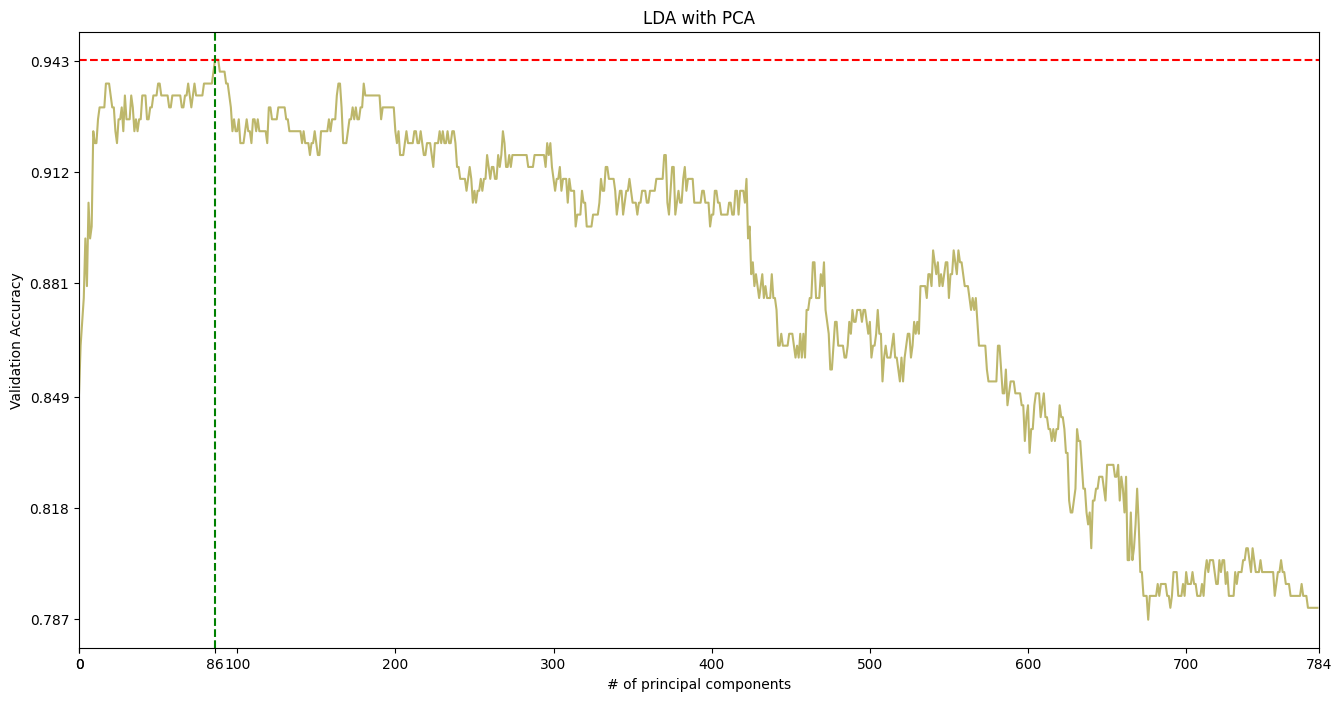

In [330]:
plot_pca(acc_lda_pca, "LDA with PCA")

# PCA with QDA

In [156]:
reg_p = [x/100 for x in range(101)]
acc_qda_pca = []
best_r = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(1, 785):
        sliced_pca_train = pca_train[:,0:i]
        sliced_pca_val = pca_val[:,0:i]
        val_metric = []
        for param in reg_p:            
            clf = QuadraticDiscriminantAnalysis(reg_param=param)
            clf.fit(sliced_pca_train, y_train)
            val_metric.append(clf.score(sliced_pca_val, y_val))
        best_r.append(reg_p[np.argmax(val_metric)])
        acc_qda_pca.append(np.max(val_metric))

In [157]:
print(f"the best result is {np.max(acc_qda_pca)} for dim {np.argmax(acc_qda_pca)} with the reg param {best_r[np.argmax(acc_qda_pca)]}")

the best result is 0.9333333333333333 for dim 568 with the reg param 0.99


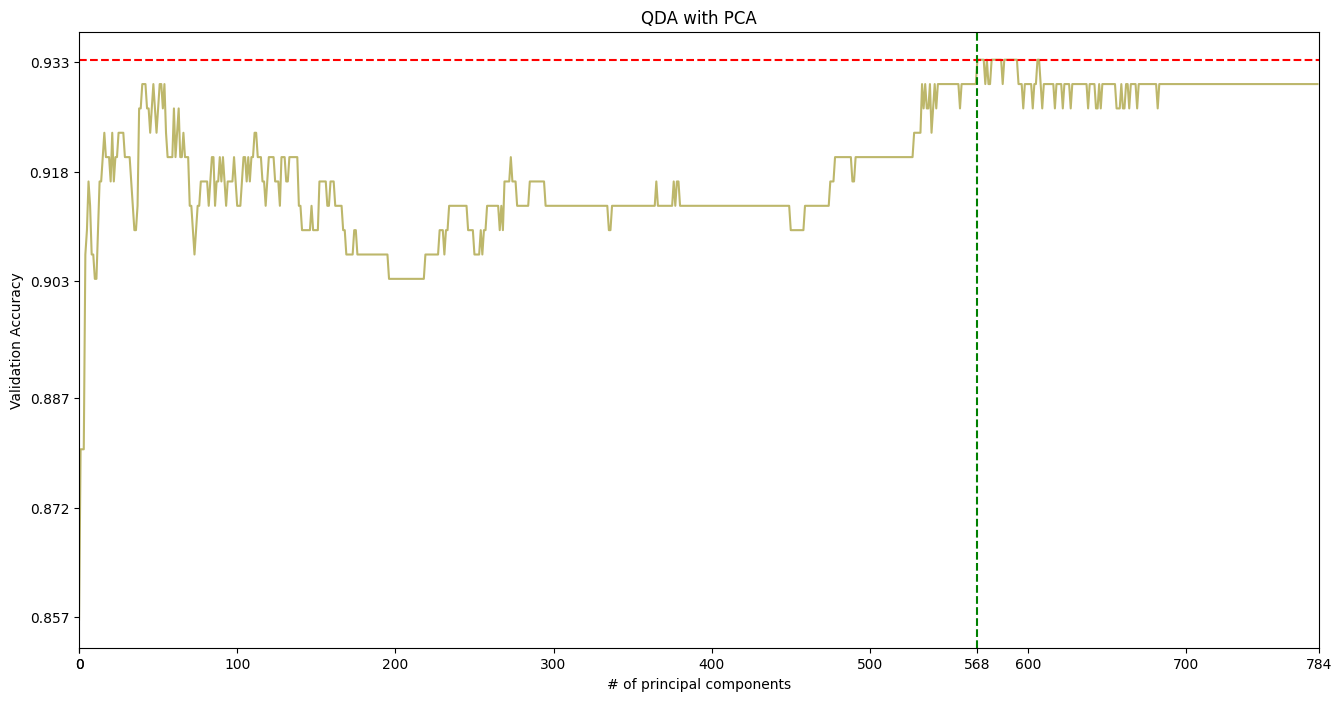

In [158]:
plot_pca(acc_qda_pca, "QDA with PCA")

# LLE

Plot function with the same idea as PCA plot. It plots the best result for the curr dimension with the best num of neighbours included (the best hyperparamets for the model are chosed each time)

In [66]:
def plot_lle(res: np.array, neig: np.array,  title: str, offset:int=0):
    plt.figure(figsize=(16, 8))

    vals = offset * [None] + res
    plt.plot(vals, "-", color="darkkhaki")
    plt.axhline(y=np.max(res), color="red", linestyle="--")
    plt.axvline(x=np.argmax(res)+offset, color="green", linestyle="--")
    
    xticks = [x*100 for x in range(8)] + [np.argmax(res) + offset, offset, 784]
    plt.xticks(ticks=xticks)
    yticks = np.round(np.linspace(np.min(res), np.max(res), 6), 3).tolist()
    plt.yticks(ticks=yticks)
    
    plt.xlim([0, 784])
    
    plt.title(title)
    plt.xlabel("# of components")
    plt.ylabel("Validation Accuracy")
    
    plt.show()

# LLE with Gaussian Naive Bayes

In [17]:
acc_gnb_lle = []
curr_best_neigh = []
neighbs = list(range(5, 50, 5))

for i in range(1, 785):
    curr_best_val = []
    for neigh_num in neighbs:
        lle = LocallyLinearEmbedding(n_components = i, n_neighbors=neigh_num)
        lle_train = lle.fit_transform(X_train)
        lle_val = lle.transform(X_val)
        clf = GaussianNB()
        clf.fit(lle_train, y_train)
        curr_best_val.append(clf.score(lle_val, y_val))
    curr_best_neigh.append(neighbs[np.argmax(curr_best_val)])
    acc_gnb_lle.append(np.max(curr_best_val))

In [96]:
print(f"the best res is {np.max(acc_gnb_lle)} with the num of components {np.argmax(acc_gnb_lle)} with the LLE num of neig: {curr_best_neigh[np.argmax(acc_gnb_lle)]}")

the best res is 0.91 with the num of components 253 with the LLE num of neig: 35


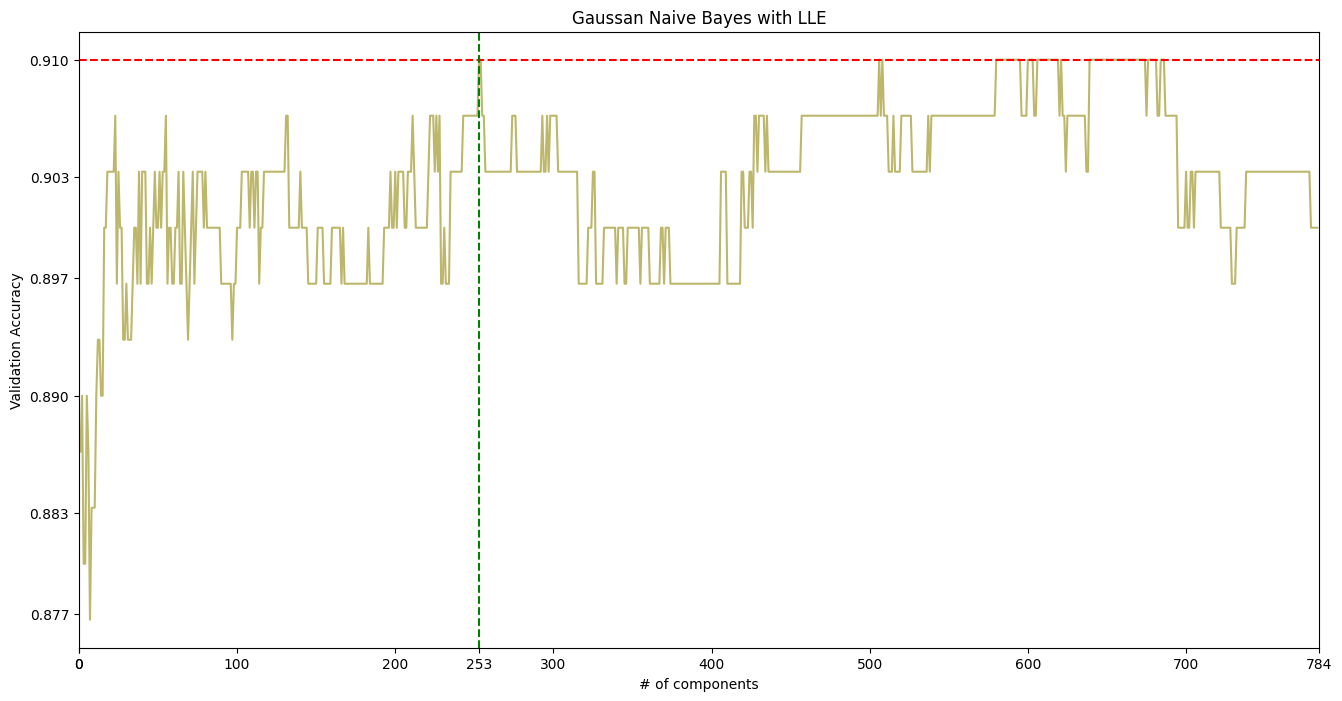

In [62]:
plot_lle(acc_gnb_lle, curr_best_neigh, "Gaussan Naive Bayes with LLE")

# LLE with LDA

In [45]:
acc_lda_lle = []
curr_best_neigh_lda = []
neighbs = list(range(5, 50, 5))

for i in range(1, 785):
    curr_best_val = []
    for neigh_num in neighbs:
        lle = LocallyLinearEmbedding(n_components = i, n_neighbors=neigh_num)
        lle_train = lle.fit_transform(X_train)
        lle_val = lle.transform(X_val)
        clf = LinearDiscriminantAnalysis()
        clf.fit(lle_train, y_train)
        curr_best_val.append(clf.score(lle_val, y_val))
    curr_best_neigh_lda.append(neighbs[np.argmax(curr_best_val)])
    acc_lda_lle.append(np.max(curr_best_val))

In [97]:
print(f"the best res is {np.max(acc_lda_lle)} with the num of components {np.argmax(acc_lda_lle)} with the LLE num of neig: {curr_best_neigh_lda[np.argmax(acc_gnb_lle)]}")

the best res is 0.96 with the num of components 141 with the LLE num of neig: 5


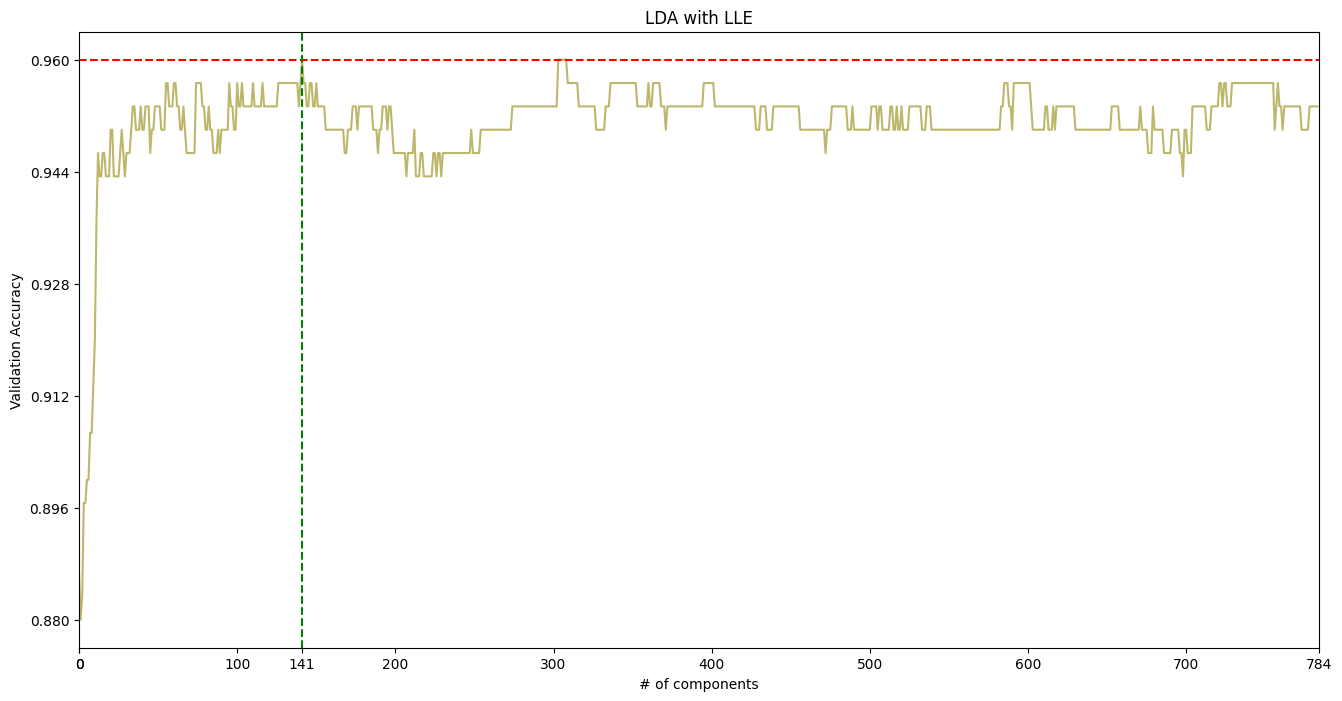

In [67]:
plot_lle(acc_lda_lle, curr_best_neigh_lda, "LDA with LLE")

# LLE with SVM

In [69]:
acc_svm_lle = []
curr_best_param_lle = []
curr_best_neigh_svm = []

param_grid = {
    "C": [0.1, 0.5, 1, 5, 20],
    "gamma": [0.001, 0.01, 0.1, 1],
    "kernel": ["rbf", "poly"]
}

param_comb = ParameterGrid(param_grid)

for i in range(10, 785):
    best_score = -1
    best_params = None
    best_neigh = None
    for neigh_num in neighbs:
        lle = LocallyLinearEmbedding(n_components=i, n_neighbors=neigh_num)
        lle_train = lle.fit_transform(X_train)
        lle_val = lle.transform(X_val)
        for params in param_comb:
            clf = SVC(**params)
            clf.fit(lle_train, y_train)
            score = clf.score(lle_val, y_val)
            if score > best_score:
                best_score = score
                best_params = params
                best_neigh = neigh_num
    acc_svm_lle.append(best_score)
    curr_best_param_lle.append(best_params)
    curr_best_neigh_svm.append(best_neigh)

In [98]:
print(f"the best res is {np.max(acc_svm_lle)} with the num of components {np.argmax(acc_svm_lle) + 10} with the LLE num of neig: {curr_best_neigh_svm[np.argmax(acc_svm_lle)]} with the params: {curr_best_param_lle[np.argmax(acc_svm_lle)]}")

the best res is 0.9666666666666667 with the num of components 77 with the LLE num of neig: 25 with the params: {'C': 20, 'gamma': 1, 'kernel': 'rbf'}


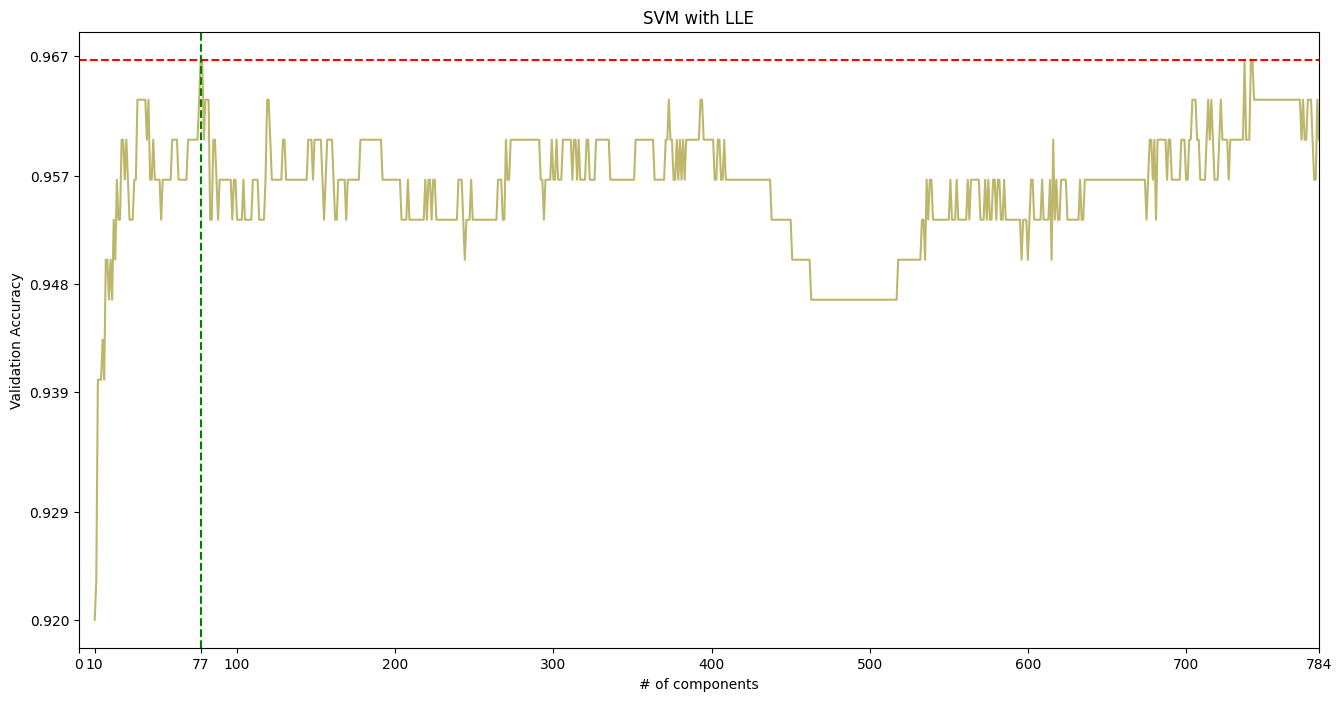

In [99]:
plot_lle(acc_svm_lle, curr_best_neigh_svm, "SVM with LLE", 10)

# LLE WITH QDA

In [151]:
acc_qda_lle = []
curr_best_neigh_qda = []
neighbs = list(range(5, 50, 5))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(1, 785):
        for neigh_num in neighbs:
            curr_best_val = []
            lle = LocallyLinearEmbedding(n_components = i, n_neighbors=neigh_num)
            lle_train = lle.fit_transform(X_train)
            lle_val = lle.transform(X_val)
            clf = QuadraticDiscriminantAnalysis()
            clf.fit(lle_train, y_train)
            curr_best_val.append(clf.score(lle_val, y_val))
        curr_best_neigh_qda.append(neighbs[np.argmax(curr_best_val)])
        acc_qda_lle.append(np.max(curr_best_val))

In [154]:
print(f"The best res is {np.max(acc_qda_lle)} with the num of components {np.argmax(acc_qda_lle)} with the LLE num of neig: {curr_best_neigh_qda[np.argmax(acc_qda_lle)]}")

The best res is 0.92 with the num of components 17 with the LLE num of neig: 5


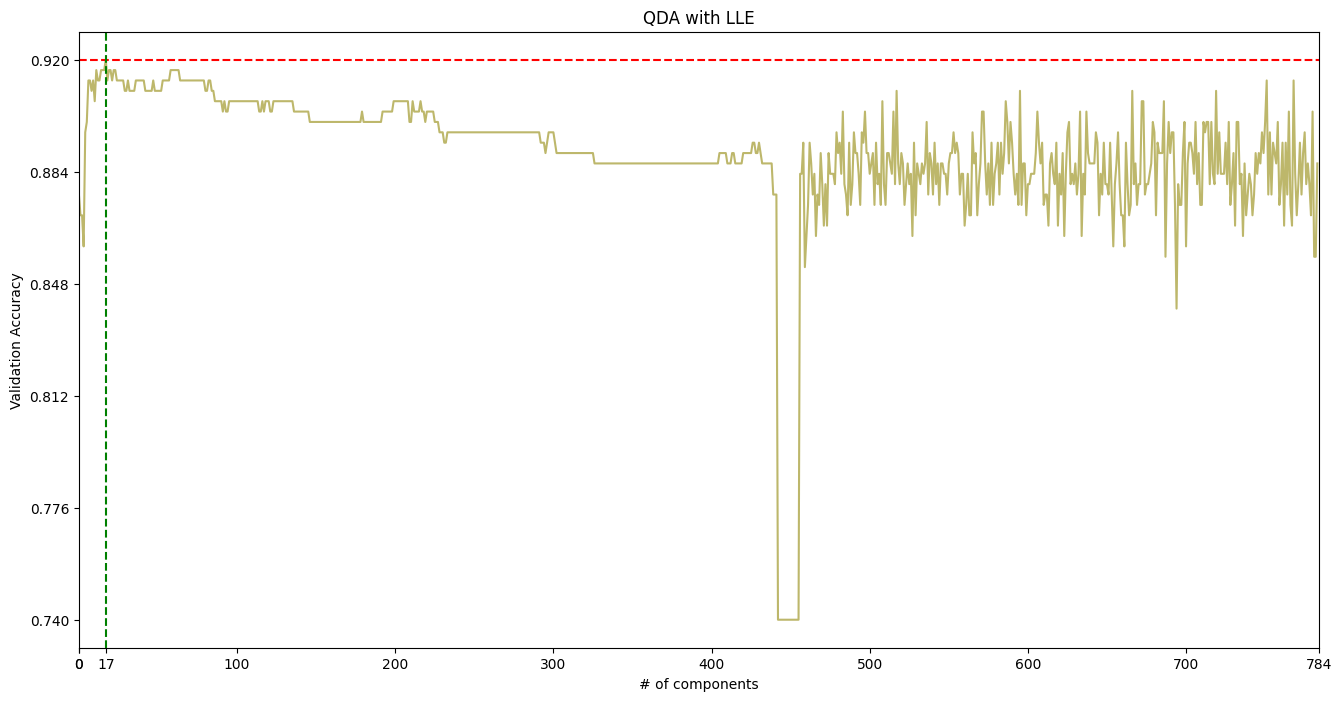

In [155]:
plot_lle(acc_qda_lle, curr_best_neigh_qda, "QDA with LLE")

# As the final model I choose SVM with LLE, as it showed the best resuts on the validation data

In [191]:
lle = LocallyLinearEmbedding(n_components=77, n_neighbors=25)
lle_train = lle.fit_transform(X_train)
lle_test = lle.transform(X_test)
best_model = SVC(C=20, gamma=1, kernel="rbf")
best_model.fit(lle_train, y_train)
print(f"The testing accuracy is {best_model.score(lle_test, y_test)} so we can expect this accuracy on the new data")

The testing accuracy is 0.9666666666666667 so we can expect this accuracy on the new data


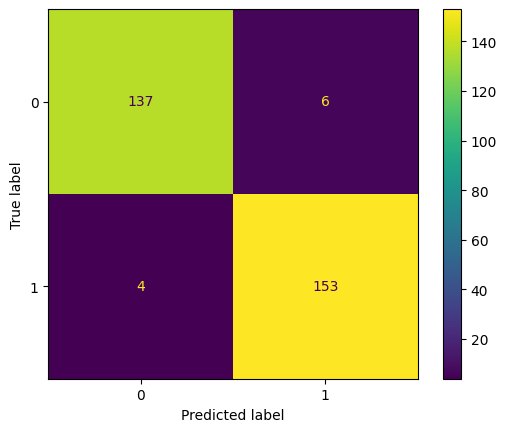

In [192]:
ConfusionMatrixDisplay.from_estimator(best_model, lle_test, y_test)
plt.show()

With the confusion matrix we see, that both classes are well balanced in performance—no obvious bias toward one, the model shows pretty good results

In [193]:
res = pd.read_csv("evaluate.csv")

In [194]:
res.isna().sum().sum()

np.int64(0)

In [195]:
ids = res.iloc[:,:0]
new_data = res.iloc[:,1:]
new_data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,87,5,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,2,0,15,144,139,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
lle_new_data = lle.transform(new_data)

In [197]:
predictions = best_model.predict(lle_new_data)

In [198]:
predictions

array([1, 0, 0, ..., 0, 0, 0], shape=(1500,))

In [199]:
ids["label"] = predictions

In [200]:
ids = ids.reset_index()
ids.columns = ["ID", "label"]

In [201]:
ids.head()

,ID,label
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0


In [202]:
ids.to_csv("results.csv", index = False)